# TP 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import random

## Ejercicio 1

In [2]:
arrival_registers = []
with open(r'archivos/datosTP2EJ1.txt', 'r') as f:
    for line in f:
        arrival_registers.append(float(line))

#### Aplico un test de Algomorov-Smirnov para testear la media de los tiempos registrados

In [3]:
arrival_registers.sort()
mean_options = [180, 240]

for opt in mean_options:

    print("H0: mean={}, H1: mean!={}".format(opt, opt))
    s,p = st.kstest(arrival_registers , 'expon', args=(0,opt))

    significance=0.01

    if(p > significance):
        print("Acepto H0 con un pvalue de " + str(p) + " con un nivel de significancia de " + str(significance))
    else:
        print("No acepto H0")

H0: mean=180, H1: mean!=180
Acepto H0 con un pvalue de 0.5735940033913054 con un nivel de significancia de 0.01
H0: mean=240, H1: mean!=240
No acepto H0


Conclusion: Los tiempos registrados siguen una distribucion exponencial con media de 180 segundos

In [4]:
THOUSAND_DAYS = 1000
FULL_DAY = 24*60*60 # in seconds

In [5]:
class Witdrawer(object):
    
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time

    def amount(self):
        return np.random.randint(3, 50)

    def transaction_time(self):
        return np.random.exponential(scale=90)

In [6]:
class Depositor(object):

    def __init__(self, arrival_time):
        self.arrival_time = arrival_time

    def amount(self):
        return np.random.randint(10,110)

    def transaction_time(self):
        return np.random.exponential(scale=500)

In [13]:
class ATM(object):

    MAXBILLS = 2000

    def __init__(self):
        self._currentBills = self.MAXBILLS
        self._occupiedAtmTime = 0
        self.totalTransactions = 0
        self.failedWithdrawers = 0
        self.transactionTimes = []
        self.bills = [self.MAXBILLS]

    def _processTime(self, client):
        waiting_time = 0
        transaction_time = client.transaction_time()
        if (client.arrival_time >= self._occupiedAtmTime):
            self._occupiedAtmTime = client.arrival_time + transaction_time

        elif (self._occupiedAtmTime > client.arrival_time):
            waiting_time = self._occupiedAtmTime - client.arrival_time
            self._occupiedAtmTime += transaction_time

        self.transactionTimes.append( transaction_time + waiting_time )

    def withdraw(self, withdrawerObj, trackBills = False):
        amount = withdrawerObj.amount()
        if (self._currentBills - amount) < 0:
            self.failedWithdrawers += 1  #Solo interesan failed withdrawers y no failed depositers?
        else:
            self._currentBills -= amount

        self.totalTransactions += 1
        self._processTime(withdrawerObj)
        if trackBills:
            self.bills.append(self._currentBills)

    def deposit(self, depositorObj, trackBills = False):
        amount = depositorObj.amount()
        if (self._currentBills + amount) > self.MAXBILLS:
            pass 
        else:
            self._currentBills += amount

        self.totalTransactions += 1
        self._processTime(depositorObj)
        if trackBills:
            self.bills.append(self._currentBills)

    def reset(self):
        self._currentBills = self.MAXBILLS
        self._occupiedAtmTime = 0

In [8]:
types = ['withdrawer','withdrawer', 'withdrawer', 'depositor']

atm = ATM()
arrival_time = 0
random_day_to_track = np.random.randint(0,1000)
for i in range(THOUSAND_DAYS):
    arrival_time = 0
    trackBills = True if i == random_day_to_track else False
    while arrival_time < FULL_DAY:
        arrival_time += np.random.exponential(scale=180)
        clientType = random.choice(types)
        if clientType == 'withdrawer':
            withdrawer = Witdrawer(arrival_time)
            atm.withdraw(withdrawer, trackBills)

        else:
            depositor = Depositor(arrival_time)
            atm.deposit(depositor, trackBills)
    atm.reset()

In [9]:
num_transactions = len(atm.bills)
x = np.arange(0, num_transactions)

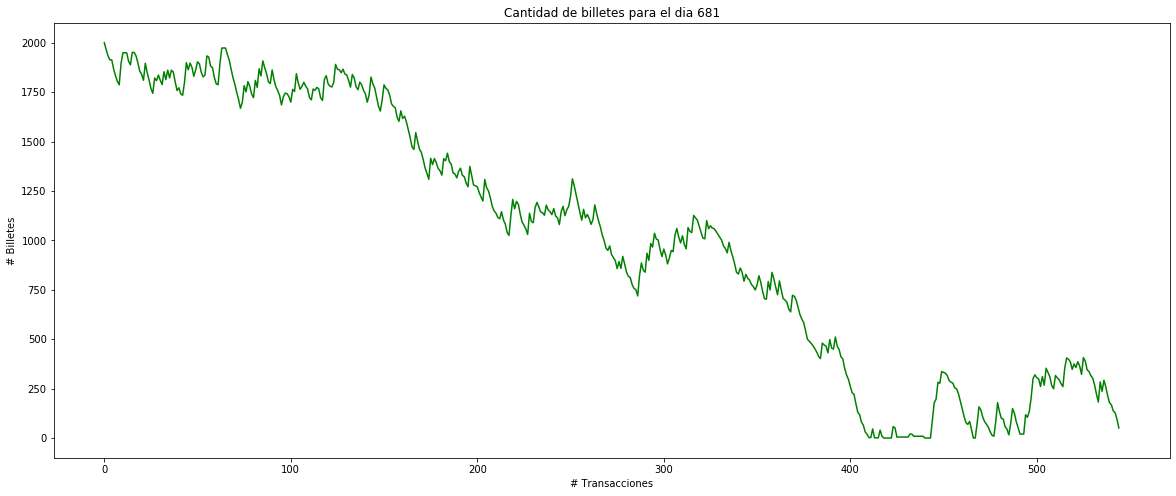

In [10]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_ylim((-100,2100)); ax.set_ylabel("# Billetes"); ax.set_xlabel("# Transacciones")
ax.set_title("Cantidad de billetes para el dia {}".format(random_day_to_track))
ax.plot(x, atm.bills, 'g')

In [11]:
print("Tiempo medio que los clientes demoraron en el sistema: {:.2f} segundos".format(np.mean(atm.transactionTimes)))

Tiempo medio que los clientes demoraron en el sistema: 5893.63 segundos


Tiempo medio de todos los clientes (tiempo de espera + tiempo usando el cajero)

In [12]:
failedTransactions = (atm.failedWithdrawers/atm.totalTransactions)*100
print("Porcentaje de clientes que se fueron sin retirar dinero: % {:.2f} ".format(failedTransactions))

Porcentaje de clientes que se fueron sin retirar dinero: % 4.65 


Como el porcentaje de clientes que se fueron sin retirar dinero es mucho menor a % 20 (porcentaje con el cajero actual) recomiendo a la empresa cambiar de cajero

## Ejercicio 2
- Determine la matriz de transición de estados explicando cómo se obtiene la misma.
- Utilizando  Matlab,  Octave  o  Python  simule  la  evolución del  sistema  a  lo  largo  de  1.000  segundos suponiendo que el servidor comienza sin estar procesando solicitudes.
- Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.
- Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.
- Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

$P = \begin{pmatrix}1-q & q \\ p & 1-p \end{pmatrix}$

$p=\frac{1}{40}, q=\frac{1}{30}$

$A$: llega una solicitud nueva al servidor

$B$: una solicitud es procesada y deja el sistema

![Markov](archivos/markov.png)

En un momento determinado, el servidor se encuentra recibiendo una solicitud nueva ($A$) o procesando una solictud ($B$). La probabilidad $p$ de que "llegue una nueva solicitud" es la probabilidad de transicionar de $B$ a $A$ y la probabilidad $q$ de que "una solicitud termine de ser procesada y deje el sistema" es la probabilidad de transicionar de $A$ a $B$. Las probabilidades de transicionar de $A$ a $A$ y $B$ a $B$ son $1-q$ y $1-p$ respectivamente.

In [24]:
estado_anterior = 'A'

# Se comienza sin solicitudes a procesar
solicitudes = []
solicitudes_en_tiempo = []

# Cantidad de eventos A
cant_sin_procesar = 0

transiciones = {
  'A -> A': 0,
  'A -> B': 0,
  'B -> B': 0,
  'B -> A': 0
};

# Realizar 10000 eventos (un evento cada 10ms por 1000seg)
for i in range(1000*10):
    u = random.random()
    if estado_anterior == 'A':
        cant_sin_procesar += 1
        if u <= 29/30:
            solicitudes.append(i)
            transiciones['A -> A'] += 1;
        else:
            try:solicitudes.pop(0)
            except:pass
            estado_anterior = 'B'
            transiciones['A -> B'] += 1;
    else:
        if u <= 39/40:
            try:solicitudes.pop(0)
            except:pass
            transiciones['B -> B'] += 1;
        else:
            solicitudes.append(i)
            estado_anterior = 'A'
            transiciones['B -> A'] += 1;
    solicitudes_en_tiempo.append(len(solicitudes))


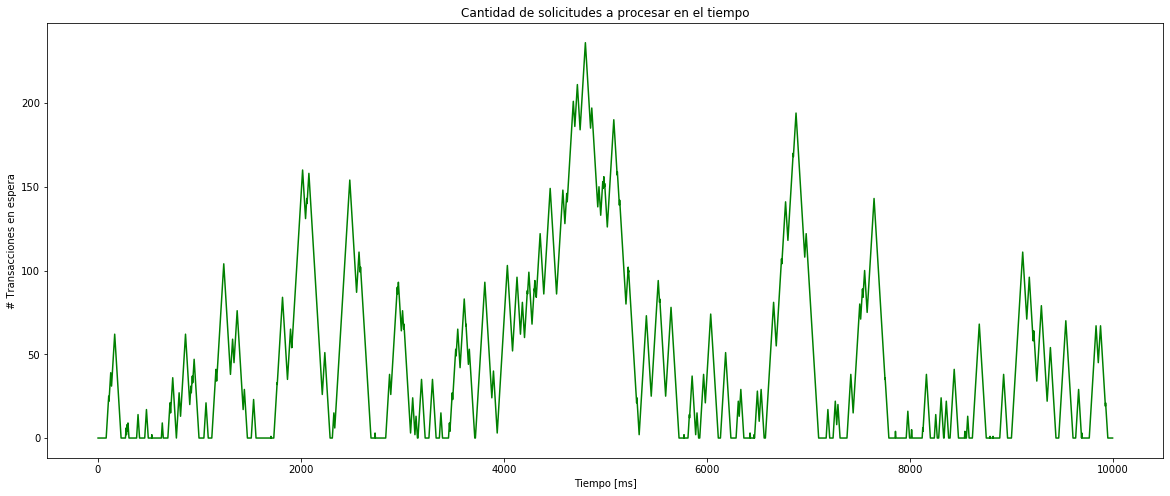

In [23]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_ylabel("# Transacciones en espera"); 
ax.set_xlabel("Tiempo [ms]")
ax.set_title("Cantidad de solicitudes a procesar en el tiempo")
ax.plot(range(10000), solicitudes_en_tiempo, 'g');

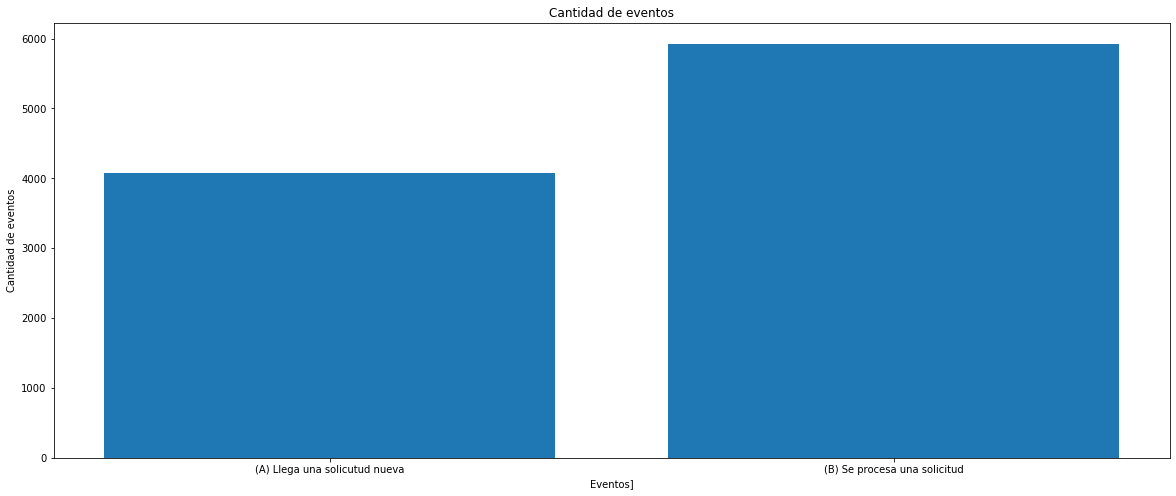

In [27]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_ylabel("Cantidad de eventos"); 
ax.set_xlabel("Eventos]")
ax.set_title("Cantidad de eventos")
ax.bar(x=['(A) Llega una solicutud nueva','(B) Se procesa una solicitud'],height=[cant_sin_procesar,10000-cant_sin_procesar]);

In [20]:
print('El servidor se encuentra un {}% del tiempo sin procesar solicitudes.'.format(cant_sin_procesar/(1000*10)*100))

El servidor se encuentra un 43.04% del tiempo sin procesar solicitudes.
